# Hourly Rainfall Disaggregation

In [1]:
from storms.precip.datasets import LoganFreeForm
from storms import Raingage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

c:\users\ckaros\src\storms\storms\_datasource.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# pull ASOS  1-minute data for tropical storm Ida
asos = Raingage.from_asos('BOS','8/30/2021','9/10/2021')

  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# aggregate to 5-minutes and find event total
asos.data.index = asos.data.index + pd.Timedelta('1H')
asos.aggregate('5T',inplace=True)
asos.find_events(inter_event_period=12,threshold_depth=0)


,event_num,event_total,start_date,event_start_index,event_end_index,hours_duration,event_max,event_records
0,1,0.02,2021-08-30 23:05:00,0,2,0.166667,0.01,2
1,2,4.23,2021-09-01 11:25:00,2,125,19.083333,0.14,123
2,3,0.04,2021-09-05 11:35:00,125,129,12.750000,0.01,4
3,4,0.96,2021-09-09 05:55:00,129,183,19.083333,0.12,55


In [4]:
# load in hourly data from included boston dataset
rg =Raingage.from_ff(LoganFreeForm,freq='1H')

# disaggreate with various methods
cont_deter=rg.disaggregate('5T','geometric_deterministic',inplace = False)
cont_stoc=rg.disaggregate('5T','geometric_stochastic',inplace = False, scale_factor=0.02)

# compute event totals
cont_deter.find_events(inter_event_period=12,threshold_depth=0)
cont_stoc.find_events(inter_event_period=12,threshold_depth=0)
rg.find_events(inter_event_period=12,threshold_depth=0)

,event_num,event_total,start_date,event_start_index,event_end_index,hours_duration,event_max,event_records
0,1,0.03,1894-01-05 14:00:00,0,2,2.0,0.02,2
1,2,0.03,1894-01-06 21:00:00,2,4,3.0,0.02,2
2,3,0.15,1894-01-10 16:00:00,4,13,13.0,0.03,9
3,4,0.09,1894-01-11 18:00:00,13,17,7.0,0.04,4
4,5,0.25,1894-01-15 23:00:00,17,26,9.0,0.05,9
...,...,...,...,...,...,...,...,...
11621,11622,0.31,2021-09-16 06:00:00,88598,88601,3.0,0.29,3
11622,11623,0.34,2021-09-18 22:00:00,88601,88605,6.0,0.15,4
11623,11624,0.03,2021-09-23 12:00:00,88605,88606,1.0,0.03,1
11624,11625,0.58,2021-09-25 19:00:00,88606,88612,12.0,0.32,6


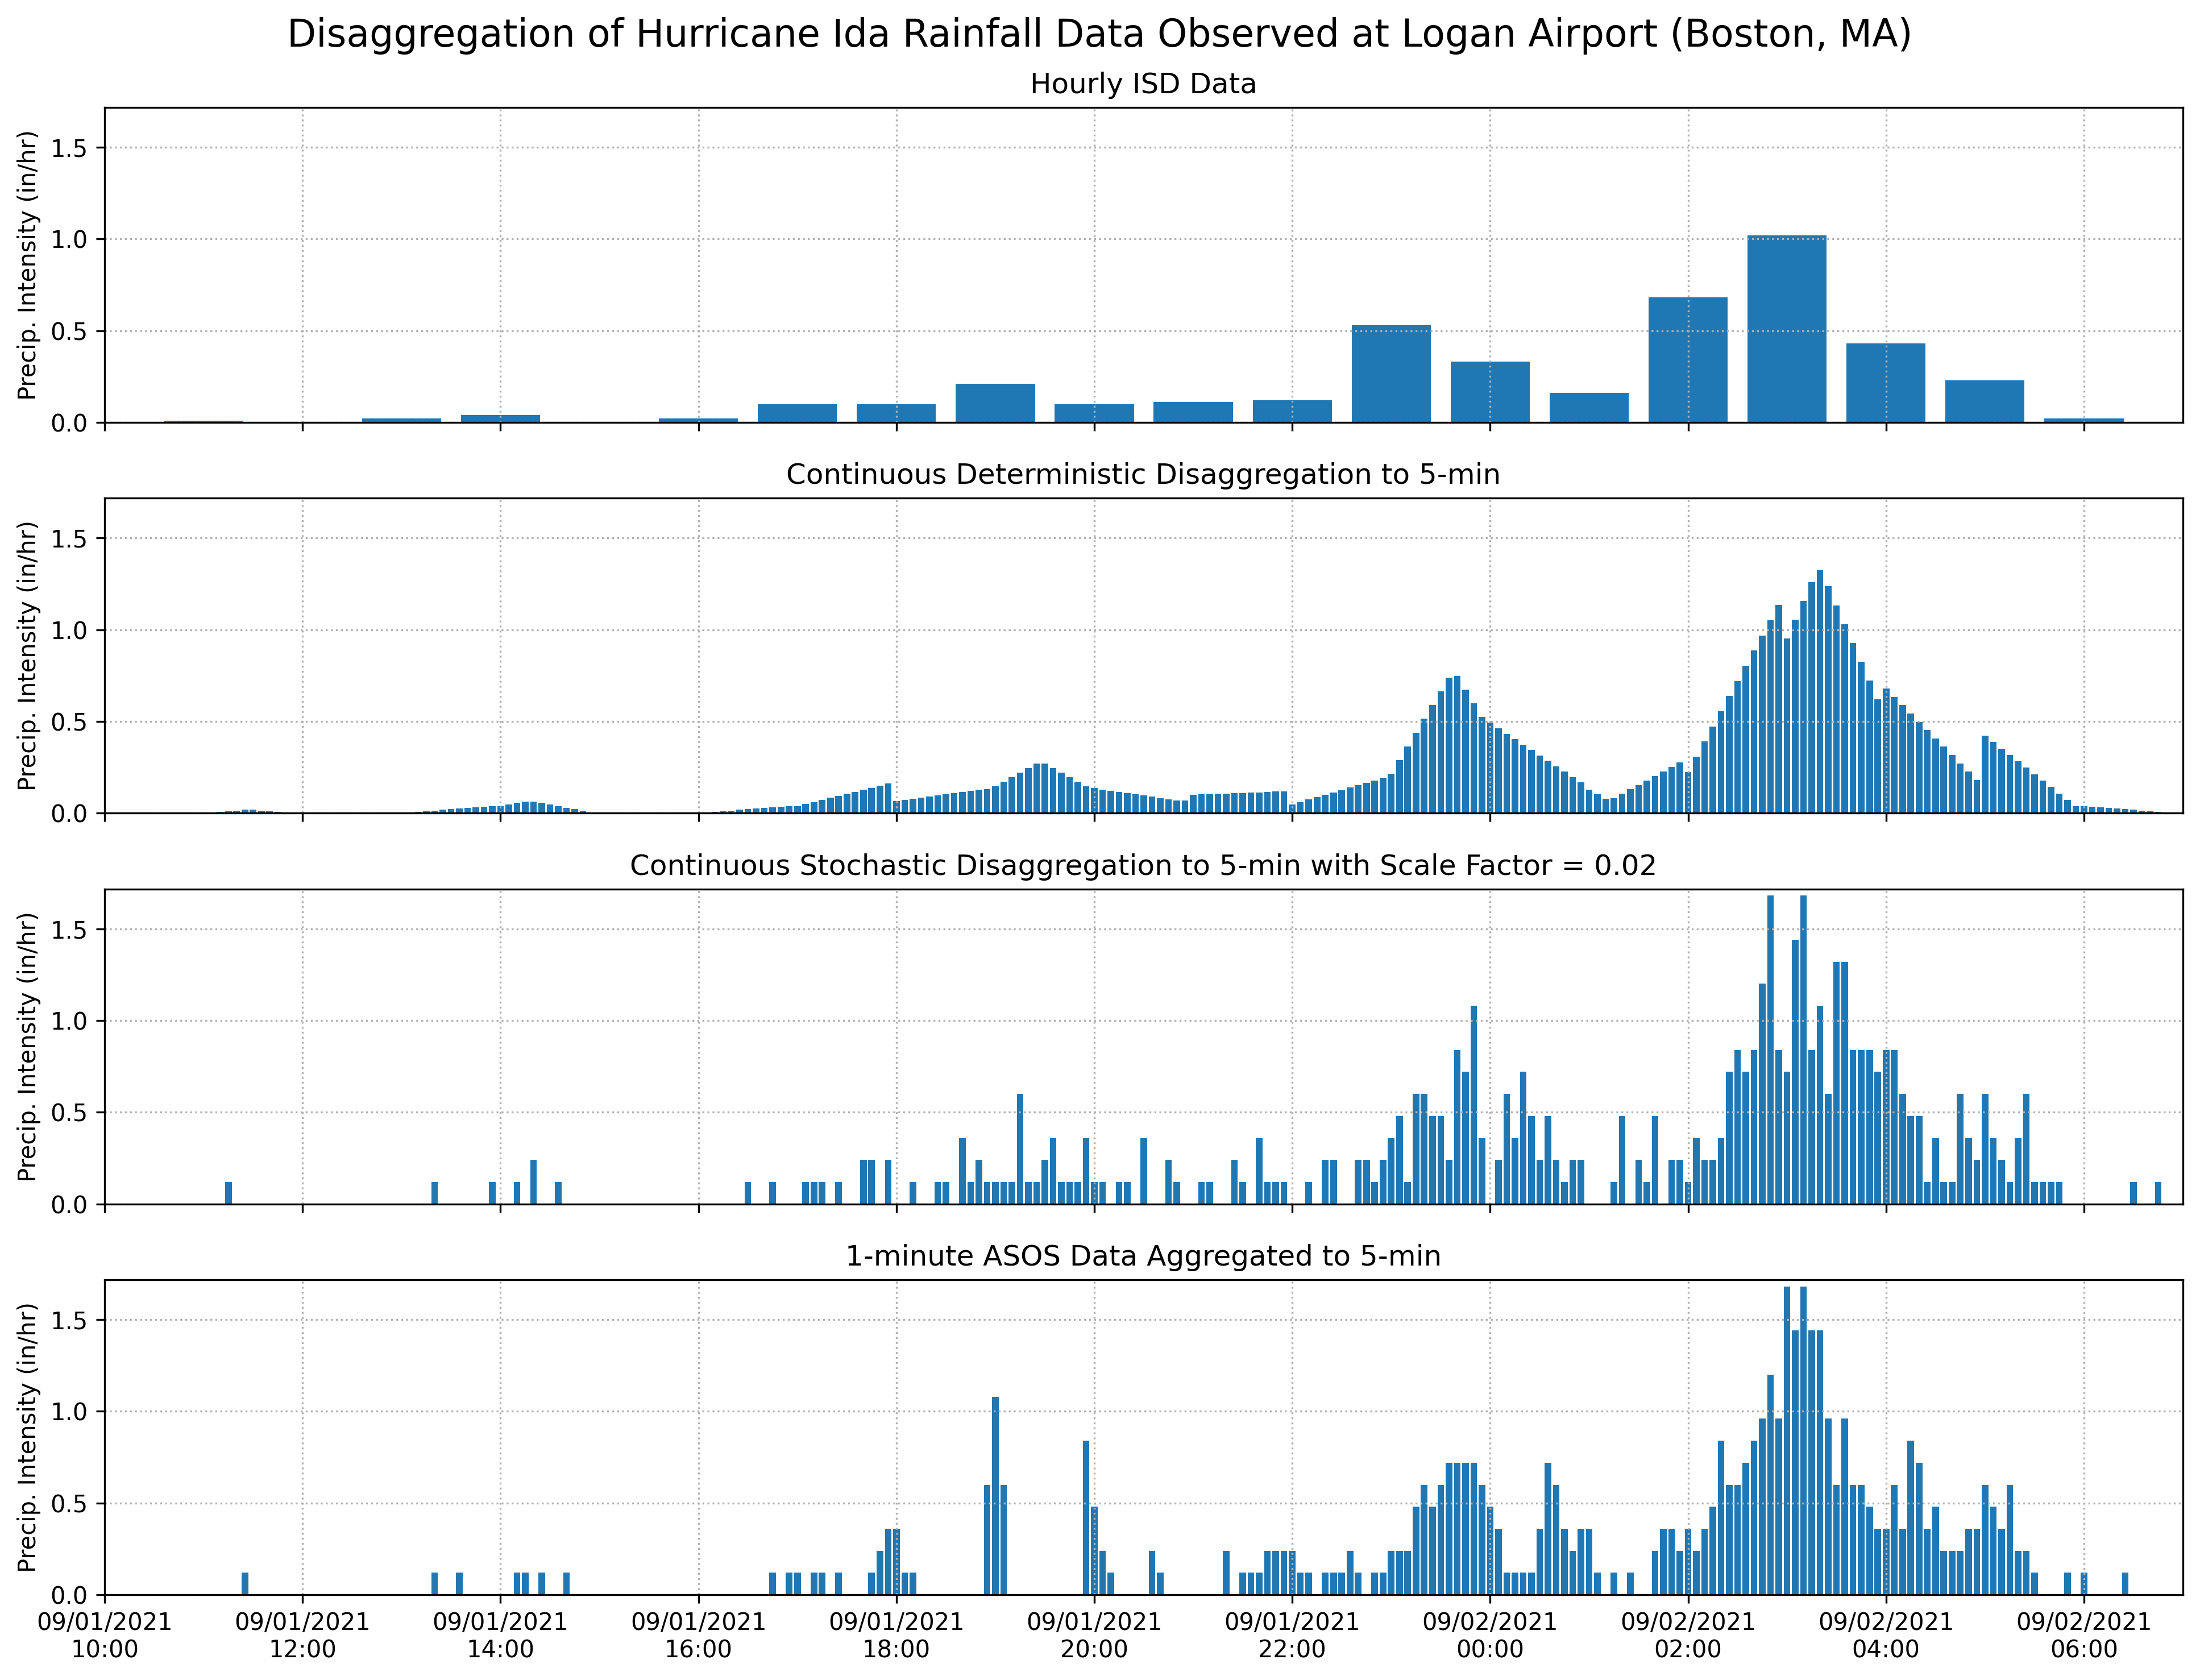

In [5]:
one_hour = 1/24
event = 37
fig,axs = plt.subplots(4,1,figsize=(13,10),dpi=300,sharex=True)

# hourly
axs[0].bar(rg.get_event_by_rank(event).index,rg.get_event_by_rank(event).to_numpy(),width=one_hour*0.8)

# deterministic
axs[1].bar(cont_deter.get_event_by_rank(event).index,cont_deter.get_event_by_rank(event).to_numpy()*12,width=one_hour/12*0.8)

# stochastic
axs[2].bar(cont_stoc.get_event_by_rank(event).index,cont_stoc.get_event_by_rank(event).to_numpy()*12,width=one_hour/12*0.8)

# ASOS
axs[3].bar(asos.get_event_by_rank(1).index,asos.get_event_by_rank(1).to_numpy()*12,width=one_hour/12*0.8)

# plot format 
myFmt = mdates.DateFormatter('%m/%d/%Y\n%H:%M')

for ax in axs:
    ax.grid(ls=':')
    ax.set_ylim(0,cont_stoc.get_event_by_rank(event-1).max()*12*1.1)
    ax.set_xlim(rg.get_event_by_rank(event).index.min() - pd.Timedelta('1H'),rg.get_event_by_rank(event).index.max()+pd.Timedelta('1H'))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Precip. Intensity (in/hr)')


axs[0].set_title('Hourly ISD Data')
axs[1].set_title('Continuous Deterministic Disaggregation to 5-min')
axs[2].set_title('Continuous Stochastic Disaggregation to 5-min with Scale Factor = 0.02')
axs[3].set_title('1-minute ASOS Data Aggregated to 5-min')

fig.suptitle("Disaggregation of Hurricane Ida Rainfall Data Observed at Logan Airport (Boston, MA)",size=16)

fig.tight_layout()
